In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/facial-keypoints-detection/test.zip
/kaggle/input/facial-keypoints-detection/IdLookupTable.csv
/kaggle/input/facial-keypoints-detection/SampleSubmission.csv
/kaggle/input/facial-keypoints-detection/training.zip


In [2]:
import os
import zipfile
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
with zipfile.ZipFile('../input/facial-keypoints-detection/training.zip', 'r') as zip_ref:
    zip_ref.extractall('train')
    
with zipfile.ZipFile('../input/facial-keypoints-detection/test.zip', 'r') as zip_ref:
    zip_ref.extractall('test')
    

Load Idlookup Table, Train and Test Dataset

In [4]:
train_data = 'train/training.csv'
test_data = 'test/test.csv'
lookid_data = '../input/facial-keypoints-detection/IdLookupTable.csv'

train_df = pd.read_csv(train_data)
test_df = pd.read_csv(test_data)
lookid_df = pd.read_csv(lookid_data)


Analyse the da

In [5]:
print(len(train_df))

train_df.head(10).T

7049


,0,1,2,3,4,5,6,7,8,9
left_eye_center_x,66.0336,64.3329,65.0571,65.2257,66.7253,69.6807,64.1319,67.4689,65.8029,64.1212
left_eye_center_y,39.0023,34.9701,34.9096,37.2618,39.6213,39.9687,34.29,39.4135,34.7552,36.7403
right_eye_center_x,30.227,29.9493,30.9038,32.0231,32.2448,29.1836,29.579,29.356,27.4758,29.4689
right_eye_center_y,36.4217,33.4487,34.9096,37.2618,38.042,37.5634,33.138,39.6217,36.1856,38.3902
left_eye_inner_corner_x,59.5821,58.8562,59.412,60.0033,58.5659,62.8643,57.7972,59.555,58.6522,58.6209
left_eye_inner_corner_y,39.6474,35.2743,36.321,39.1272,39.6213,40.1693,35.154,40.4548,37.3293,37.8406
left_eye_outer_corner_x,73.1303,70.7227,70.9844,72.3147,72.5159,76.8982,69.0266,75.5916,72.953,71.272
left_eye_outer_corner_y,39.97,36.1872,36.321,38.381,39.8845,41.1719,34.29,40.0382,35.8995,37.2903
right_eye_inner_corner_x,36.3566,36.0347,37.6781,37.6186,36.9824,36.401,34.7617,37.4782,36.3424,36.3446
right_eye_inner_corner_y,37.3894,34.3615,36.321,38.7541,39.0949,39.3676,33.714,40.4548,37.0432,39.4905


In [6]:
print(train_df.isnull().values.ravel().sum())
print(len(train_df.dropna()))
train_df.fillna(method= 'ffill', inplace= True)

105412
2140


In [7]:
print(len(test_df))
print(test_df.isnull().values.ravel().sum())
test_df.head(10)

1783
0


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...
1,2,76 87 81 72 65 59 64 76 69 42 31 38 49 58 58 4...
2,3,177 176 174 170 169 169 168 166 166 166 161 14...
3,4,176 174 174 175 174 174 176 176 175 171 165 15...
4,5,50 47 44 101 144 149 120 58 48 42 35 35 37 39 ...
5,6,177 177 177 171 142 115 97 84 89 90 88 82 63 5...
6,7,77 55 44 56 58 61 67 66 65 65 65 73 72 78 86 9...
7,8,156 160 162 166 150 114 97 105 125 127 119 121...
8,9,230 230 231 231 231 231 231 231 231 229 214 20...
9,10,132 129 126 128 146 163 170 169 143 101 71 55 ...


Prepare Train Data

In [8]:

train_data = []

for image in train_df['Image'].values:
    img = image.split(' ')
    image_array = [0 if '' == img[i] else img[i] for i in range(len(img))]
#     image_array = image_array.reshape(96, 96, 1)
    train_data.append(image_array)
    



train_data = np.asarray(train_data, np.float32)
train_data = train_data.reshape(-1, 96, 96, 1)
print(train_data.shape)



(7049, 96, 96, 1)


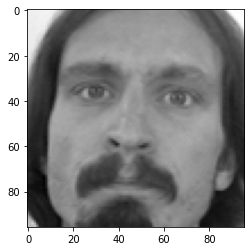

In [10]:
image = train_data[0]
plt.imshow(image.reshape(96, 96), cmap='gray')

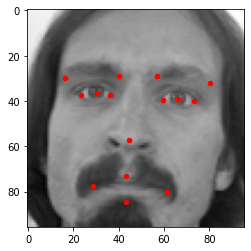

In [11]:
train_labels = train_df.drop('Image', axis= 1).to_numpy(dtype= np.float32)
plt.imshow(train_data[0].reshape(96, 96), cmap= 'gray')
plt.scatter(train_labels[0][0::2], train_labels[0][1::2], marker='o',color= 'red', s=20)

Data Preprocessing

1. Data Augmentation by Horizontal Flipping

In [12]:
def horizontal_flip(image, keypoint):
    flipped_image = np.flip(image, axis= 1)
    flipped_keypoint = [(image.shape[0] - keypoint[i]) if (i % 2 == 0) else keypoint[i] for i in range(len(keypoint))]
    return flipped_image, np.asarray(flipped_keypoint, dtype= np.float32)

flipped_image_list = []
flipped_keypoint_list = []
for i in range(train_data.shape[0]):
    flipped_image, flipped_keypoint = horizontal_flip(train_data[i], train_labels[i])
    flipped_image_list.append(flipped_image)
    flipped_keypoint_list.append(flipped_keypoint)
    


    

In [13]:
# train_labels.shape
print(np.array(flipped_keypoint_list).shape)

(7049, 30)


In [14]:
train_data = np.concatenate((train_data, flipped_image_list), axis= 0)
train_labels = np.concatenate((train_labels, np.asarray(flipped_keypoint_list, np.float32)), axis= 0)
print(train_data.shape)
print(train_labels.shape)

(14098, 96, 96, 1)
(14098, 30)


Prepare Test Data

In [15]:
test_df.isnull().values.ravel().sum()
test_data = []
for image in test_df['Image'].to_numpy():
    img = image.split(' ')
    image_array = [0 if img[i] == '' else img[i] for i in range(len(img))]
    test_data.append(image_array)


test_data = np.asarray(test_data, np.float32)
test_data = train_data.reshape(-1, 96, 96, 1)
test_data.shape


(14098, 96, 96, 1)

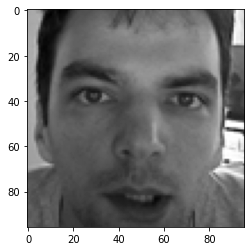

In [16]:
img = test_data[5]
plt.imshow(img.reshape(96, 96), cmap= 'gray')

Build Model

In [17]:
import tensorflow as tf
import keras

model = keras.Sequential(
[
    keras.layers.Conv2D(32, (3, 3), padding= 'same', use_bias=False, input_shape= (96, 96, 1)),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(), 
    
    keras.layers.Conv2D(32, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(), 
    
    keras.layers.Conv2D(64, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(), 
    
    keras.layers.Conv2D(64, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(), 
    
    keras.layers.Conv2D(128, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(128, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(), 
    
    keras.layers.Conv2D(256, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(), 
    
    keras.layers.Conv2D(256, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(512, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(512, (3, 3), padding= 'same', use_bias=False),
    keras.layers.LeakyReLU(alpha= 0.1),
    keras.layers.MaxPooling2D(2, 2),
    keras.layers.BatchNormalization(),
    
    keras.layers.Flatten(),
    
    keras.layers.Dense(512, activation= 'relu'),
    keras.layers.Dropout(0.8),
    
    keras.layers.Dense(256, activation= 'relu'),
    keras.layers.Dropout(0.6), 
    
        
    keras.layers.Dense(30),
    
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 48, 48, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 32)        1

In [18]:
model.compile(
    optimizer= 'adam',
    loss = 'mean_squared_error',
    metrics = ['mae', 'acc'],
             )

In [19]:
print(train_data.shape)
print(type(train_data))
print(train_labels.shape)
print(type(train_labels))

print(test_data.shape)
print(type(test_data))


(14098, 96, 96, 1)
<class 'numpy.ndarray'>
(14098, 30)
<class 'numpy.ndarray'>
(14098, 96, 96, 1)
<class 'numpy.ndarray'>


In [20]:
history = model.fit(
    train_data,
    train_labels,
    epochs= 250,
    validation_split= 0.2,
    batch_size= 256,
)

Epoch 1/250
45/45 [==============================] - 5s 122ms/step - loss: 775.3905 - mae: 21.7647 - acc: 0.0874 - val_loss: 610.3380 - val_mae: 19.0914 - val_acc: 3.5461e-04
Epoch 2/250
45/45 [==============================] - 5s 104ms/step - loss: 416.3175 - mae: 15.9402 - acc: 0.1235 - val_loss: 482.5735 - val_mae: 16.1770 - val_acc: 0.0262
Epoch 3/250
45/45 [==============================] - 5s 105ms/step - loss: 366.2907 - mae: 14.7739 - acc: 0.1337 - val_loss: 16123.9395 - val_mae: 93.4949 - val_acc: 0.1340
Epoch 4/250
45/45 [==============================] - 5s 105ms/step - loss: 341.5512 - mae: 14.1059 - acc: 0.1422 - val_loss: 736.3224 - val_mae: 19.5678 - val_acc: 0.1947
Epoch 5/250
45/45 [==============================] - 5s 104ms/step - loss: 335.6389 - mae: 13.9952 - acc: 0.1434 - val_loss: 8014.3491 - val_mae: 59.1987 - val_acc: 0.2106
Epoch 6/250
45/45 [==============================] - 5s 104ms/step - loss: 321.2090 - mae: 13.5962 - acc: 0.1536 - val_loss: 385.3752 - va

Epoch 49/250
45/45 [==============================] - 5s 106ms/step - loss: 229.3161 - mae: 11.0943 - acc: 0.3711 - val_loss: 349.0673 - val_mae: 14.4464 - val_acc: 0.2113
Epoch 50/250
45/45 [==============================] - 5s 104ms/step - loss: 228.9248 - mae: 11.0179 - acc: 0.3724 - val_loss: 315.3604 - val_mae: 13.0117 - val_acc: 0.2113
Epoch 51/250
45/45 [==============================] - 5s 107ms/step - loss: 225.5906 - mae: 10.9461 - acc: 0.3738 - val_loss: 345.9916 - val_mae: 14.4466 - val_acc: 0.2113
Epoch 52/250
45/45 [==============================] - 5s 105ms/step - loss: 244.6115 - mae: 11.5312 - acc: 0.3739 - val_loss: 405.2669 - val_mae: 15.8792 - val_acc: 0.2113
Epoch 53/250
45/45 [==============================] - 5s 104ms/step - loss: 229.4189 - mae: 11.0624 - acc: 0.3760 - val_loss: 450.9262 - val_mae: 16.4217 - val_acc: 0.2113
Epoch 54/250
45/45 [==============================] - 5s 105ms/step - loss: 228.8227 - mae: 11.0846 - acc: 0.3769 - val_loss: 404.2998 - val

Epoch 97/250
45/45 [==============================] - 5s 104ms/step - loss: 220.2531 - mae: 10.7446 - acc: 0.3790 - val_loss: 350.8909 - val_mae: 13.9237 - val_acc: 0.2113
Epoch 98/250
45/45 [==============================] - 5s 103ms/step - loss: 221.5993 - mae: 10.8010 - acc: 0.3788 - val_loss: 330.0003 - val_mae: 13.0896 - val_acc: 0.2113
Epoch 99/250
45/45 [==============================] - 5s 103ms/step - loss: 219.4034 - mae: 10.7364 - acc: 0.3793 - val_loss: 304.8512 - val_mae: 12.7426 - val_acc: 0.2113
Epoch 100/250
45/45 [==============================] - 5s 106ms/step - loss: 220.0562 - mae: 10.7266 - acc: 0.3791 - val_loss: 321.5996 - val_mae: 13.2208 - val_acc: 0.2113
Epoch 101/250
45/45 [==============================] - 5s 105ms/step - loss: 218.4957 - mae: 10.7185 - acc: 0.3792 - val_loss: 367.9471 - val_mae: 14.9304 - val_acc: 0.2113
Epoch 102/250
45/45 [==============================] - 5s 105ms/step - loss: 222.0131 - mae: 10.7914 - acc: 0.3791 - val_loss: 329.6161 - 

45/45 [==============================] - 5s 104ms/step - loss: 211.2631 - mae: 10.4366 - acc: 0.3791 - val_loss: 303.6740 - val_mae: 11.4913 - val_acc: 0.2113
Epoch 145/250
45/45 [==============================] - 5s 105ms/step - loss: 210.4312 - mae: 10.3956 - acc: 0.3792 - val_loss: 294.0525 - val_mae: 12.1314 - val_acc: 0.2113
Epoch 146/250
45/45 [==============================] - 5s 103ms/step - loss: 213.0132 - mae: 10.5035 - acc: 0.3792 - val_loss: 502.2398 - val_mae: 16.9750 - val_acc: 0.2113
Epoch 147/250
45/45 [==============================] - 5s 105ms/step - loss: 212.5456 - mae: 10.4940 - acc: 0.3791 - val_loss: 450.4531 - val_mae: 15.3091 - val_acc: 0.2113
Epoch 148/250
45/45 [==============================] - 5s 104ms/step - loss: 213.6222 - mae: 10.5527 - acc: 0.3791 - val_loss: 288.6352 - val_mae: 11.1648 - val_acc: 0.2113
Epoch 149/250
45/45 [==============================] - 5s 104ms/step - loss: 210.5950 - mae: 10.4114 - acc: 0.3791 - val_loss: 283.7108 - val_mae: 10

45/45 [==============================] - 5s 104ms/step - loss: 201.8684 - mae: 10.0720 - acc: 0.3794 - val_loss: 264.6871 - val_mae: 10.6162 - val_acc: 0.2113
Epoch 192/250
45/45 [==============================] - 5s 104ms/step - loss: 201.7869 - mae: 10.0994 - acc: 0.3794 - val_loss: 288.8533 - val_mae: 10.9828 - val_acc: 0.2110
Epoch 193/250
45/45 [==============================] - 5s 104ms/step - loss: 200.4311 - mae: 10.0190 - acc: 0.3792 - val_loss: 284.0064 - val_mae: 10.9798 - val_acc: 0.2113
Epoch 194/250
45/45 [==============================] - 5s 104ms/step - loss: 203.6023 - mae: 10.1006 - acc: 0.3794 - val_loss: 342.3284 - val_mae: 12.3003 - val_acc: 0.2113
Epoch 195/250
45/45 [==============================] - 5s 103ms/step - loss: 201.1662 - mae: 10.0368 - acc: 0.3794 - val_loss: 293.0111 - val_mae: 10.8926 - val_acc: 0.2113
Epoch 196/250
45/45 [==============================] - 5s 104ms/step - loss: 201.2657 - mae: 10.0550 - acc: 0.3794 - val_loss: 476.1982 - val_mae: 15

Epoch 239/250
45/45 [==============================] - 5s 106ms/step - loss: 155.9063 - mae: 8.2712 - acc: 0.3723 - val_loss: 338.1431 - val_mae: 11.5135 - val_acc: 0.2113
Epoch 240/250
45/45 [==============================] - 5s 104ms/step - loss: 152.2766 - mae: 8.1600 - acc: 0.3725 - val_loss: 303.6552 - val_mae: 10.8817 - val_acc: 0.2113
Epoch 241/250
45/45 [==============================] - 5s 104ms/step - loss: 151.7987 - mae: 8.1644 - acc: 0.3680 - val_loss: 328.4182 - val_mae: 11.2743 - val_acc: 0.2113
Epoch 242/250
45/45 [==============================] - 5s 104ms/step - loss: 151.4527 - mae: 8.1478 - acc: 0.3692 - val_loss: 351.7414 - val_mae: 11.7023 - val_acc: 0.2113
Epoch 243/250
45/45 [==============================] - 5s 104ms/step - loss: 147.9321 - mae: 7.9844 - acc: 0.3685 - val_loss: 376.2309 - val_mae: 12.0581 - val_acc: 0.2113
Epoch 244/250
45/45 [==============================] - 5s 104ms/step - loss: 145.8766 - mae: 7.9404 - acc: 0.3685 - val_loss: 324.4626 - val

Visualize Graphs

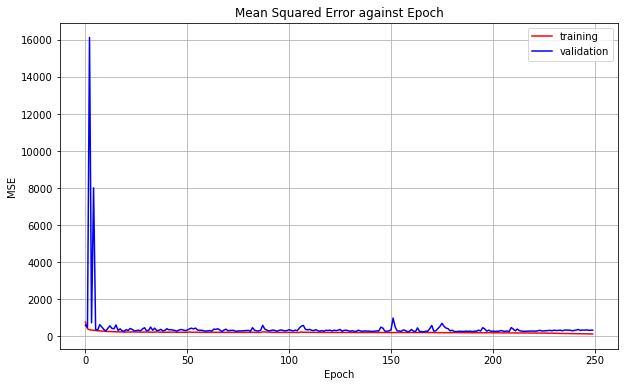

In [21]:
plt.figure(figsize= (10, 6))
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch = range(len(loss))
plt.plot(epoch, loss, 'r', label= 'training')
plt.plot(epoch, val_loss, 'b', label= 'validation')
plt.title('Mean Squared Error against Epoch')
plt.grid()
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.savefig('graph.png')

Prediction on Test Data

In [22]:
pred = model.predict(test_data)

In [23]:
pred.shape

(14098, 30)

Preparing for Submission

In [24]:
ImageId = lookid_df['ImageId']
FeatureName = lookid_df["FeatureName"]
RowId = lookid_df["RowId"]

submit = []
for rowId,irow,landmark in zip(RowId,ImageId,FeatureName):
    print(landmark)
    submit.append([rowId, pred[landmark].iloc[irow-1]])

submit = DataFrame(submit,columns=["RowId","Location"])
## adjust the scale 
print(submit.shape)

left_eye_center_x


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [25]:
lookid_list = list(lookid_df['FeatureName'])
imageID = list(lookid_df['ImageId']-1)
pre_list = list(pred)

rowid = lookid_df['RowId']
rowid=list(rowid)

In [26]:
feature = []
for f in list(lookid_df['FeatureName']):
    feature.append(lookid_list.index(f))


In [27]:
preded = []
for x,y in zip(imageID,feature):
    preded.append(pre_list[x][y])

In [28]:
rowid = pd.Series(rowid,name = 'RowId')
loc = pd.Series(preded,name = 'Location')
submission = pd.concat([rowid,loc],axis = 1)
submission.to_csv('face_key_detection_submission.csv',index = False)